In [1]:
import data_visualization as dv
import file_processing as fp
import gazetteer as gz
from utils import join_rows

import pandas as pd
from joblib import Parallel, delayed
from sklearn.cluster import KMeans

PATH_GEONAMES = '../Data/Unprocessed/GeoNames/US.txt'
PATH_TEXT = '../Data/Unprocessed/full_text.txt'
PATH_STATE_CITY = '../Data/Unprocessed/state_city.txt'
PATH_BOUNDARIES = '../Data/Unprocessed/NaturalEarth/ne_110m_admin_0_countries.shp'

PATH_DATA = '../Data/Processed/data.csv'
PATH_GAZETTEER = '../Data/Processed/gazetteer.csv'
PATH_METADATA = '../Data/Processed/metadata.csv'

PATH_TRAIN = '../Data/Training/train.csv'
PATH_TEST = '../Data/Training/test.csv'
PATH_DEV = '../Data/Training/dev.csv'

%matplotlib inline

/home/kiryn/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kiryn/anaconda3/envs/torch/lib/python3.10/site-packages/thinc/shims/pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

In [2]:
print("Loading datafile...")

df = pd.read_csv(PATH_TEXT, delimiter='\t', na_values=["", "NA"], encoding='utf-8', encoding_errors='replace')
state_city = pd.read_csv(PATH_STATE_CITY, delimiter='\t', na_values=["", "NA"], encoding='utf-8', encoding_errors='replace')

print("Loading complete")
print("Rows in datafile: ", len(df))
print("-------------------------------------")
print("Filtering non-US coordinates...")

boundaries = fp.get_boundaries(PATH_BOUNDARIES, 'United States of America')
df = fp.filter_coordinates(df, boundaries).drop('geometry', axis=1)
state_city = fp.filter_coordinates(state_city, boundaries).drop('geometry', axis=1)

print("Filtering complete")
print("Rows in filtered datafile: ", len(df))
print("-------------------------------------")
print("Cleaning data...")

df = fp.clean_df(pd.merge(df, state_city, on=['latitude', 'longitude'], how='inner'))
df = df[['user_id', 'index', 'hour', 'weekday', 'city', 'state', 'latitude', 'longitude', 'text']]
df.to_csv(PATH_DATA, index=False, encoding='utf-8')

print("Cleaning complete")

Loading datafile...
Loading complete
Rows in datafile:  376511
-------------------------------------
Filtering non-US coordinates...
Filtering complete
Rows in filtered datafile:  358347
-------------------------------------
Cleaning data...
Cleaning complete


In [ ]:
print("Loading datafile...")

df_geo = pd.read_csv(PATH_GEONAMES, sep='\t', header=None, 
    names=[
        'geonameid', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country_code', 'cc2', 
        'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'elevation', 'dem', 'timezone', 'modification_date'
    ],
    low_memory=False
)[['name', 'alternatenames', 'population', 'latitude', 'longitude']]

for col in df_geo.select_dtypes(include='object').columns:
    df_geo[col] = df_geo[col].str.lower()

print("Loading complete")
print("Rows in datafile: ", len(df_geo))

print("-------------------------------------")
print("Joining rows by 'name'...")

df_geo_reduced = pd.DataFrame(
    Parallel(n_jobs=-1, verbose=1)(
        delayed(join_rows)(group, 'name', use_gpu=False) for _, group in df_geo.groupby('name')
    )
)

df_geo_reduced.to_csv(PATH_GAZETTEER, index=False, encoding='utf-8')

print("Join complete")
print("Rows in joined datafile: ", len(df_geo_reduced))

In [2]:
df = pd.read_csv(PATH_DATA, delimiter=',')
temp_df = pd.DataFrame(df['index'])
temp_df['text'] = df['text'] + ', ' + df['city'].astype(str) + ', ' + df['state'].astype(str)

df_metadata = gz.generate_metadata(temp_df, PATH_GAZETTEER)
df_metadata.to_csv(PATH_METADATA, index=False, encoding='utf-8')

Extracting geographic entities...


Processing Batches: 100%|██████████| 180/180 [57:48<00:00, 19.27s/it]


Extraction complete
-------------------------------------
Generating metadata...
Generation complete
-------------------------------------
Concatenating metadata...


Processing Groups: 100%|██████████| 356885/356885 [55:35<00:00, 107.00it/s] 


Concatination complete
-------------------------------------
Rows with metadata: 356885 (99.59%)



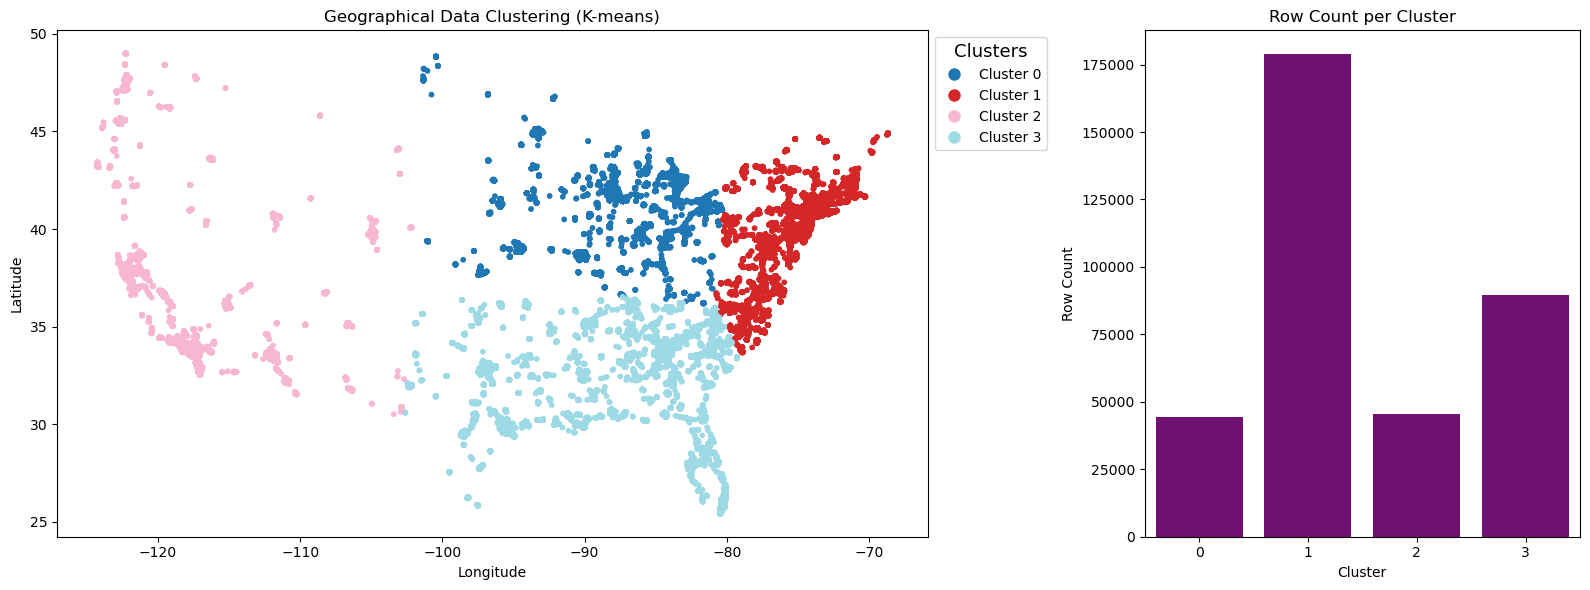

Number of samples: 358347
Train length: 322512
Test length: 17918
Dev length: 17917


In [2]:
CLUSTERS = 4
kmeans = KMeans(n_clusters=CLUSTERS, random_state=0)
df = pd.read_csv(PATH_DATA)

df['cluster'] = kmeans.fit_predict(df[['longitude', 'latitude']])
cluster_stats = dv.get_stats(df)

dv.show_stats(df, cluster_stats)
print(f"Number of samples: {len(df)}")

df = df[['index', 'hour', 'weekday', 'cluster', 'latitude', 'longitude', 'text']]

fp.split_data(df, PATH_TRAIN, PATH_TEST, PATH_DEV)